In [1]:
import gzip
import json

In [2]:
fname = "file_metadata_v2.json.gz"

with gzip.open(fname) as f:
    content = json.loads(f.read().decode())

# content = dict((k,v) for k,v in content.items() if "ttbar" not in k)  # filter if needed

In [3]:
sum_nfiles_input = 0
sum_size_input_GB = 0
sum_nevts_input = 0

sum_nfiles_output = 0
sum_size_output_GB = 0

sizes_output_GB = []
avg_sizes_output_GB = []
nfiles_output = []

all_file_size = []

for category_info in content.values():
    for k, dataset_info in category_info.items():
        if dataset_info["nevts_input"] is None:
            print(f"[empty input] skipping {k}")  # skip empty input containers
            continue

        sum_nfiles_input += dataset_info["nfiles_input"]
        sum_size_input_GB += dataset_info["size_input_GB"]
        sum_nevts_input += dataset_info["nevts_input"]

        if dataset_info["nfiles_output"] is not None:  # skip missing tasks
            sum_nfiles_output += dataset_info["nfiles_output"]
            sum_size_output_GB += dataset_info["size_output_GB"]
            sizes_output_GB.append(dataset_info["size_output_GB"])
            avg_sizes_output_GB.append(dataset_info["size_output_GB"] / dataset_info["nfiles_output"])
            nfiles_output.append(dataset_info["nfiles_output"])
            all_file_size += dataset_info["sizes_output_GB"]

        else:
            print(f"[empty output] {k}")


print("PHYSLITE INPUT")
print(f"  nfiles:    {sum_nfiles_input:,}")
print(f"  size [GB]: {sum_size_input_GB:,.0f}")
print(f"  nevents:   {sum_nevts_input:,}")

print("NTUPLE OUTPUT")
print(f"  nfiles:    {sum_nfiles_output:,}")
print(f"  size [GB]: {sum_size_output_GB:,.0f}")

[empty input] skipping mc23_13p6TeV.700789.Sh_2214_Zmumu_maxHTpTV2_BFilter.deriv.DAOD_PHYSLITE.e8514_s4162_r15540_p6491
[empty input] skipping mc23_13p6TeV.700790.Sh_2214_Zmumu_maxHTpTV2_CFilterBVeto.deriv.DAOD_PHYSLITE.e8514_s4162_r15540_p6491
PHYSLITE INPUT
  nfiles:    876,601
  size [GB]: 565,268
  nevents:   59,187,536,268
NTUPLE OUTPUT
  nfiles:    8,039
  size [GB]: 17,327


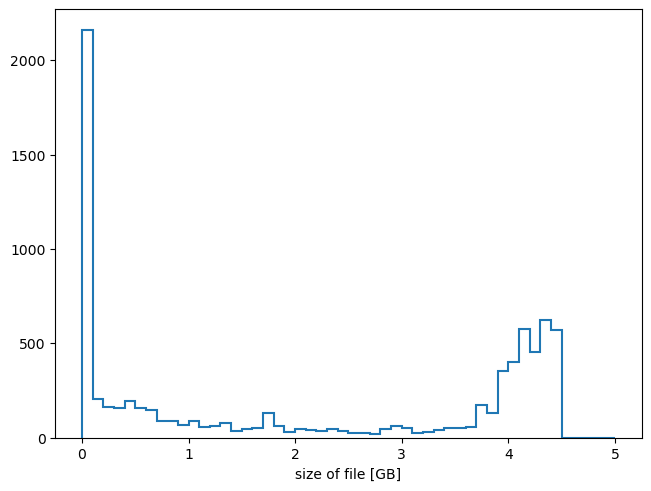

In [4]:
import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots(constrained_layout=True)

hist.new.Regular(50, 0, 5, label="size of file [GB]").Double().fill(all_file_size).plot(ax=ax, yerr=False)
fig.savefig("file_sizes.pdf")
# 

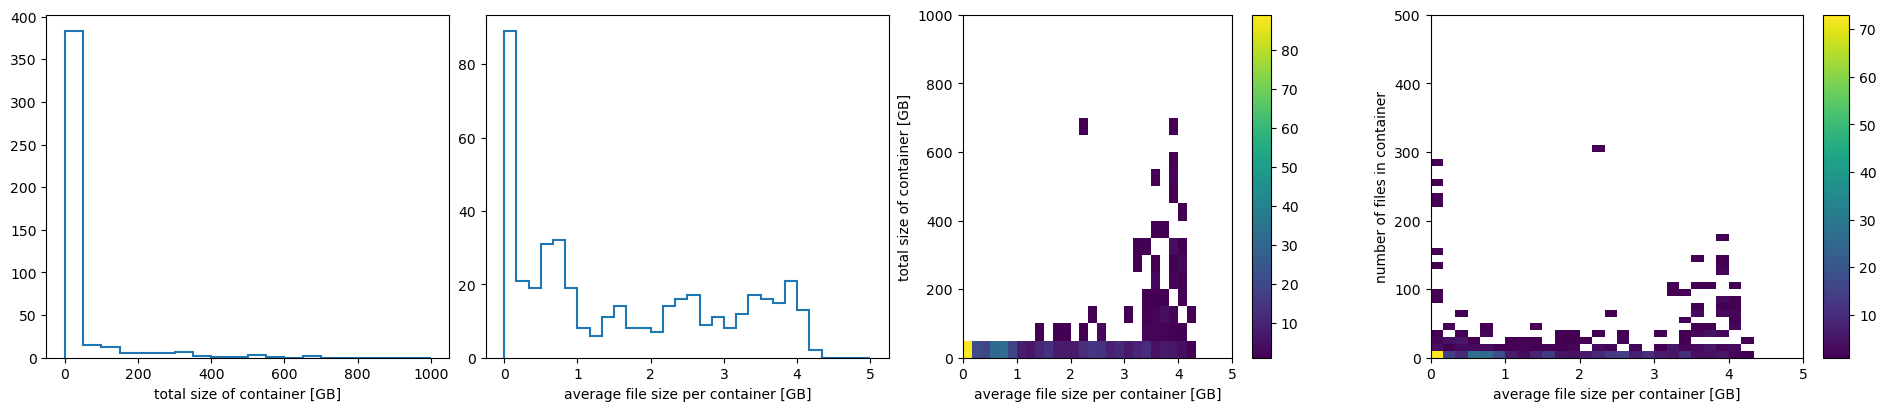

In [5]:
import hist
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(16, 4), ncols=4, constrained_layout=True)

hist.new.Regular(20, 0, 1_000, label="total size of container [GB]").Double().fill(sizes_output_GB).plot(ax=ax1, yerr=False)
h = hist.new.Regular(30, 0, 5, label="average file size per container [GB]").Double().fill(avg_sizes_output_GB).plot(ax=ax2, yerr=False)

h = hist.new.Regular(30, 0, 5, label="average file size per container [GB]").Regular(20, 0, 1_000, label="total size of container [GB]").Double()
_ = h.fill(avg_sizes_output_GB, sizes_output_GB).plot(ax=ax3, cmin=1)

h = hist.new.Regular(30, 0, 5, label="average file size per container [GB]").Regular(50, 0, 500, label="number of files in container").Double()
_ = h.fill(avg_sizes_output_GB, nfiles_output).plot(ax=ax4, cmin=1)
fig.savefig("ntuple_summary.pdf")

## Total number of events in ntuples (with Dask)

In [6]:
import collections

import dask.bag
from dask.distributed import Client
import uproot

client = Client("tls://localhost:8786")


def get_entries(fpath_and_cat):
    fpath, cat = fpath_and_cat
    try:
        num_entries = uproot.open({fpath: "reco"}).num_entries
    except (uproot.KeyInFileError, OSError):
        num_entries = 0  # empty file
    return collections.Counter({cat: num_entries})


total_sum = 0
all_files = []
for cat, category_info in content.items():
    for dataset_info in category_info.values():
        if dataset_info["files_output"] is not None:
            all_files += [(di, cat) for di in dataset_info["files_output"]]

print(f"extracting event numbers for {len(all_files)} files")

b = dask.bag.from_sequence(all_files)
futures = b.map(get_entries)
task = futures.fold(lambda x,y: x+y, split_every=4)
res = dask.compute(task)

for k, v in res[0].items():
    print(f"{k:>12}: {v:,}")

print(f"\ntotal: {sum(res[0].values()):,}")

extracting event numbers for 8039 files
    Hplus_cb: 1,662,365
    Hplus_cs: 1,052,909
          Wt: 10,782,426
       Wt_DS: 8,581,461
       Wt_H7: 9,397,060
        data: 25,555,166
     diboson: 46,570,582
    rare_top: 45,477,119
    st_schan: 1,632,747
    st_tchan: 6,125,241
         ttV: 48,354,222
    ttbar_H7: 222,588,446
 ttbar_hdamp: 219,781,496
   ttbar_nom: 256,454,615
       wjets: 81,801,563
       zjets: 136,474,616

total: 1,122,292,034


In [7]:
# calculate total runtime on the grid (with caveats)
# https://atlas-talk.web.cern.ch/t/calculating-total-runtime-of-a-task/48343/4
with open("production_status.json") as f:
    content = json.load(f)

tot_hs06sec = 0
for c in content:
    if c["cputime"] is not None:
        assert c["cputimeunit"] == "mHS06sPerEvent"
        tot_hs06sec += c["cputime"] / 1000 * c["dsinfo"]["neventsUsedTot"]
    # else:
    #     print(c["jeditaskid"])

print(f"{tot_hs06sec/60/60:,.0f} HS06-hours")
print(f"{tot_hs06sec/60/60/10:,.0f} core hours (assuming average of 10 HS06/core)")

7,661,250 HS06-hours
766,125 core hours (assuming average of 10 HS06/core)
